# Matriz de risco da Abraji (2019–2024)
**Avaliação de ameaças físicas, digitais e legais a jornalistas no brasil**

**Autoria:** Reinaldo Chaves (coordenação) — Abraji  
**Versão do notebook:** v1.0 · **Última atualização:** agosto de 2025
**Escopo dos dados:** 2019–2024 (histórico); **janela analítica:** 2021–2024 (maior completude)  
**Parceiros e referências operacionais:** Voces del Sur; Media Defence

## Objetivo
Construir e atualizar uma **matriz de risco** para priorizar ações de segurança **física, digital e legal**, combinando **probabilidade (likelihood)** e **impacto (severity)** por **região (regiao_norm)** e **tipo de agressão (tipo_agressao_norm)**, com recortes por **canal** (digital/físico). A abordagem segue padrões de gestão e avaliação de risco amplamente adotados (ISO 31000; NIST SP 800-30) e, no eixo digital, dialoga com o OWASP Risk Rating e relatórios setoriais de DDoS (Cloudflare Radar).

## O que este notebook faz
1. **Carrega e limpa** os dados históricos (2019–2024), removendo linhas vazias e padronizando colunas.  
2. **Normaliza** taxonomias: `regiao_norm`, `tipo_agressao_norm`, `digital_flag`, `ator_agressor`.  
3. **Calcula** probabilidade por contexto com suavização (Laplace) e mapeia para quintis (1–5).  
4. **Atribui** impacto (1–5) via codebook + ajustes automáticos por sinais de gravidade.  
5. **Compõe** `risk_score = likelihood_score × impact_score` (1–25) e `risk_class`.  
6. **Gera** tabelas e heatmaps por canal (digital/físico) e exporta artefatos (CSV/XLSX/PNG).  

## Dados e reprodutibilidade
- **Fonte:** base consolidada da Abraji (2019–2024) + fontes secundárias públicas.  
- **Janela analítica padrão:** 2021–2024 (comparabilidade e menor viés de completude).  
- **Seed e ambiente:** ver célula “Setup” com versões de Python e pacotes (pandas, numpy, matplotlib, unidecode, etc.).  
- **Artefatos gerados:** `matriz_risco_regiao_tipo.xlsx`, `matriz_risco_heatmap_digital.png`, `matriz_risco_heatmap_fisico.png`.  
- **Governança:** versionar codebook (tipos/impactos), limiares de quintis e pesos por ano; revisar trimestralmente (ISO 31000 — melhoria contínua).

## Limitações conhecidas
- **Subnotificação** e **heterogeneidade** entre fontes; impacto digital pode ser subestimado sem métricas de indisponibilidade/escala.  
- As **faixas** de risco (baixo/médio/alto/crítico) e os **pesos** por ano são parâmetros do projeto e podem ser recalibrados conforme a base cresce (NIST/ISO).

## Referências essenciais
- ISO — **ISO 31000:2018, Risk management — Guidelines**.   
- NIST — **SP 800-30 Rev.1, Guide for Conducting Risk Assessments**.
- OWASP — **Risk Rating Methodology** (likelihood × impact no contexto digital).  
- Cloudflare Radar — **Quarterly DDoS threat reports** (tendências e severidade).

> **Contato:** <reichaves@gmail.com> · **Licença/uso:** de acordo com as políticas da Abraji e acordos com parceiros.

In [ ]:
!pip install -q openai rapidfuzz Unidecode pandas xlsxwriter

In [ ]:
import os, json, time, unicodedata, re
import pandas as pd
from unidecode import unidecode
from rapidfuzz import process, fuzz
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# --- caminho e abas ---
path = "/drive/My Drive/Data-driven/thomson_media/Base de dados - Matriz de risco.xlsx"
abas = ["2019","2020","2021","2022","2023","2024"]

# --- placeholders que viram NaN ---
NA_VALUES = ["", " ", "  ", "-", "—", "N/A", "NA", "nan", "NaN", "None",
             "FALSO", "FALSE", "VERDADEIRO", "TRUE", "falso", "false", "verdadeiro", "true"]


In [ ]:
# --- colunas esperadas por ABA (NOMES ORIGINAIS, só tiraremos espaços no início/fim) ---
EXPECTED = {
    "2024": [
        "codigo_ocorrencia","num_alerta","organizacao_que_coletou_dados","dia","mes","cidade_estado","regiao",
        "resumo_titulo","link","tipo_agressao","detalhe_agressao","vitimas","nome_vitima","genero_vitima",
        "genero_detalhado","fatores_interseccao","faixa_idade","veiculo_de_midia","origem_do_agressor",
        "genero_agressor","nome_do_agressor","ataque_de_genero","motivo","meio_digital"
    ],
    "2023": [
        "codigo_ocorrencia","num_alerta","organizacao_que_coletou_dados","dia","mes","cidade_estado","regiao",
        "resumo_titulo","link","tipo_agressao","detalhe_agressao","vitimas","nome_vitima","genero_vitima",
        "genero_detalhado","fatores_interseccao","faixa_idade","veiculo_de_midia","origem_do_agressor",
        "genero_agressor","nome_do_agressor","ataque_de_genero","motivo","meio_digital"
    ],
    "2022": [
        "codigo_ocorrencia","num_alerta","organizacao_que_coletou_dados","dia","mes","cidade_estado","regiao",
        "resumo_titulo","link","tipo_agressao","detalhe_agressao","nome_vitima","genero_vitima",
        "genero_detalhado","razao_ataque","faixa_idade","veiculo_de_midia","origem_do_agressor",
        "genero_agressor","nome_agressor","ataque_de_genero","tipo_ataque_de_genero","motivo_ataque_digital","meio_digital"
    ],
    "2021": [
        "codigo_ocorrencia","num_alerta","organizacao_que_coletou_dados","dia","mes","cidade_estado","regiao",
        "resumo_titulo","link","tipo_vitima","nome_vitima","genero_vitima","faixa_idade","veiculo_de_midia",
        "origem_do_agressor","nome_agressor","tipo_agressao","meio_digital","ataque_de_genero"
    ],
    "2020": [
        "num_alerta","tipo_agressao","local_estado_pais","cidade","tipo_vitima","nome_vitima","veiculo_de_midia",
        "detalhe_agressao","resumo_agressao","origem_do_agressor","nome_agressor","local_agressao",
        "meio_digital","data_agressao","link"
    ],
    "2019": [
        "num_alerta","tipo_agressao","local_estado_pais","cidade","nome_vitima","veiculo_de_midia",
        "detalhe_agressao","resumo_agressao","nome_agressor","origem_do_agressor","data_agressao","link"
    ],
}

In [ ]:
# util: normaliza lista de nomes (apenas strip, mantém acentos)
def _strip_list(cols):
    return [c.strip() for c in cols]

EX_STRIPPED = {aba: set(_strip_list(cols)) for aba, cols in EXPECTED.items()}

def carregar_aba(sheet_name: str, min_campos_validos: int = 2):
    # 1) lê a aba
    df = pd.read_excel(path, sheet_name=sheet_name, dtype=str, na_values=NA_VALUES)
    # 2) nomes de coluna: só strip
    df.columns = pd.Index(df.columns).astype(str).str.strip()
    # 3) limpar células: placeholders e espaços vazios -> NaN
    df = df.replace({k: pd.NA for k in NA_VALUES}).replace(r"^\s*$", pd.NA, regex=True)
    # 4) descartar colunas 100% vazias
    df = df.dropna(axis="columns", how="all")

    # 5) whitelisting de colunas (mantém só as esperadas daquela aba)
    expected = EX_STRIPPED.get(sheet_name, set())
    # se a aba tiver alguma coluna inesperada, guardamos para inspeção
    found = set(df.columns)
    extras = sorted(list(found - expected))
    missing = sorted(list(expected - found))
    if extras:
        print(f"[{sheet_name}] colunas extras removidas:", extras)
    if missing:
        print(f"[{sheet_name}] colunas esperadas ausentes:", missing)
    keep = [c for c in df.columns if c in expected]
    df = df[keep].copy()

    # 6) filtro de linhas: exige >= 2 campos válidos (exceto 'vitimas', se existir)
    cols_contar = [c for c in df.columns if c.strip().lower() != "vitimas"]
    valid_count = df[cols_contar].notna().sum(axis=1)
    df = df.loc[valid_count >= min_campos_validos].copy()

    # 7) procedência
    df["origem_dado_nas_abas"] = sheet_name
    m = re.search(r"(\d{4})", sheet_name)
    df["ano"] = int(m.group(1)) if m else pd.NA
    return df

In [ ]:
# --- executa para cada aba e concatena ---
dfs = [carregar_aba(aba, min_campos_validos=2) for aba in abas]
df_all = pd.concat(dfs, ignore_index=True)

/tmp/ipython-input-3229712959.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({k: pd.NA for k in NA_VALUES}).replace(r"^\s*$", pd.NA, regex=True)


[2021] colunas extras removidas: ['1', 'Abraji', 'Acceso a la información', 'Enero', 'Estatal', 'Femenino', 'Menor de 18', 'Mestizo', 'Norte', 'Reporteros y analistas']


/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [ ]:
# coloca ano/origem no início, mantendo o restante no ordenamento original de cada aba
primeiras = ["ano", "origem_dado_nas_abas"]
resto = [c for c in df_all.columns if c not in primeiras]
df_all = df_all[primeiras + resto]

In [ ]:
# checagens
print("\nlinhas por ano:")
print(df_all["ano"].value_counts().sort_index())
print("\nqtd colunas:", df_all.shape[1])
print("\nprimeiras colunas:", df_all.columns[:20].tolist())


linhas por ano:
ano
2019      84
2020     366
2021     623
2022    1038
2023     409
2024     256
Name: count, dtype: int64

qtd colunas: 36

primeiras colunas: ['ano', 'origem_dado_nas_abas', 'num_alerta', 'tipo_agressao', 'local_estado_pais', 'cidade', 'nome_vitima', 'veiculo_de_midia', 'detalhe_agressao', 'resumo_agressao', 'nome_agressor', 'origem_do_agressor', 'data_agressao', 'link', 'tipo_vitima', 'local_agressao', 'meio_digital', 'codigo_ocorrencia', 'organizacao_que_coletou_dados', 'dia']


In [ ]:
df_all.to_excel('/drive/My Drive/Data-driven/thomson_media/dados_reunidos_thomsonmedia.xlsx',sheet_name='Sheet1',index=False)

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   ano                            2776 non-null   int64 
 1   origem_dado_nas_abas           2776 non-null   object
 2   num_alerta                     2775 non-null   object
 3   tipo_agressao                  2776 non-null   object
 4   local_estado_pais              392 non-null    object
 5   cidade                         386 non-null    object
 6   nome_vitima                    2775 non-null   object
 7   veiculo_de_midia               2751 non-null   object
 8   detalhe_agressao               1756 non-null   object
 9   resumo_agressao                448 non-null    object
 10  nome_agressor                  2106 non-null   object
 11  origem_do_agressor             2775 non-null   object
 12  data_agressao                  442 non-null    object
 13  lin

In [ ]:
path = "/drive/My Drive/Data-driven/thomson_media/dados_reunidos_thomsonmedia.xlsx"
df = pd.read_excel(path, sheet_name = 'Sheet1', dtype = 'str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   ano                            2776 non-null   object
 1   origem_dado_nas_abas           2776 non-null   object
 2   num_alerta                     2775 non-null   object
 3   tipo_agressao                  2776 non-null   object
 4   local_estado_pais              392 non-null    object
 5   cidade                         386 non-null    object
 6   nome_vitima                    2775 non-null   object
 7   veiculo_de_midia               2751 non-null   object
 8   detalhe_agressao               1756 non-null   object
 9   resumo_agressao                448 non-null    object
 10  nome_agressor                  2106 non-null   object
 11  origem_do_agressor             2775 non-null   object
 12  data_agressao                  442 non-null    object
 13  lin

# Coluna tipo_agressao - normalizar

In [ ]:
# ---------------------------------------------------------------
# CLIENTE OPENAI (novo SDK)
from openai import OpenAI
client = None
if USE_OPENAI:
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        print("⚠️ Variável OPENAI_API_KEY não encontrada. Tradução via API será ignorada.")
        USE_OPENAI = False
    else:
        client = OpenAI(api_key=api_key)

In [ ]:
# lista CANÔNICA (expandida p/ cobrir seu conjunto real)
CANON = [
    "agressões e ataques",
    "ameaça",
    "assassinato",
    "detenção/prisão",
    "processos judiciais",
    "discurso estigmatizante",
    "violência online",
    "violência offline",
    "restrições na internet",
    "acesso à informação",
    "obstrução/confisco",
    "invasão a redação",
    "assédio/hostilização",
    "violência sexual",
    "uso abusivo do poder estatal",
    "marco jurídico/regulatório",
]

# 1) MAPEAMENTO DIRETO (PT/ES + typos frequentes)  ——> CANON
# tudo em minúsculas + sem acento
MAP = {
    # casos citados por você
    "casos judiciais": "processos judiciais",
    "uso de poder politico": "uso abusivo do poder estatal",
    "detencao abritraria": "detenção/prisão",     # typo
    "detencao arbitraria": "detenção/prisão",
    "restricao no acesso a informacao": "acesso à informação",
    "marco juridico contrario as normas internacionais": "marco jurídico/regulatório",
    "uso abusivo del poder estatal": "uso abusivo do poder estatal",
    "procesos civiles y procesos penales": "processos judiciais",
    "procesos civiles": "processos judiciais",
    "procesos penales": "processos judiciais",
    "procesos civiles y procesos penales": "processos judiciais",
    "procesos civiles y procesos penales": "processos judiciais",
    "asesinatos": "assassinato",

    # sinônimos/variantes gerais
    "agresiones y ataques": "agressões e ataques",
    "agresion": "agressões e ataques",
    "agresiones": "agressões e ataques",
    "ataque": "agressões e ataques",

    "amenaza": "ameaça",
    "amenazas": "ameaça",

    "detencion": "detenção/prisão",
    "prision": "detenção/prisão",
    "detencion arbitraria": "detenção/prisão",

    "procesos y sentencias judiciales": "processos judiciais",
    "procesos judiciales": "processos judiciais",
    "assedio judicial": "processos judiciais",

    "discurso de odio": "discurso estigmatizante",
    "estigmatizacion": "discurso estigmatizante",

    "violencia en linea": "violência online",
    "violencia online": "violência online",
    "violencia fuera de linea": "violência offline",
    "violencia offline": "violência offline",

    "restricciones en internet": "restrições na internet",
    "bloqueo de internet": "restrições na internet",
    "censura en internet": "restrições na internet",

    "acceso a la informacion": "acesso à informação",
    "acesso a informacao": "acesso à informação",

    "confiscacion de equipos": "obstrução/confisco",
    "confisco": "obstrução/confisco",
    "aprehension de equipos": "obstrução/confisco",
    "obstruccion": "obstrução/confisco",

    "invasion a la redaccion": "invasão a redação",
    "allanamiento de redaccion": "invasão a redação",

    "hostigamiento": "assédio/hostilização",
    "persecucion": "assédio/hostilização",
    "acoso": "assédio/hostilização",

    "violencia sexual": "violência sexual",
    "acoso sexual": "violência sexual",
}

# correções ortográficas mínimas antes de mapear
CORRECOES = [
    (r"\babritr", "arbitr"),  # 'abritrária' -> 'arbitrária'
    (r"informaci[oó]n", "informacion"),
]

In [ ]:
def norm_basic(s):
    if pd.isna(s): return ""
    s = str(s).strip().lower()
    s = unidecode(s)
    for pat, rep in CORRECOES:
        s = re.sub(pat, rep, s)
    s = re.sub(r"\s+", " ", s)
    return s

# ===== IA RESTRITA AOS RÓTULOS CANÔNICOS =====
client = None
if USE_OPENAI:
    if not os.getenv("OPENAI_API_KEY"):
        print("⚠️ Sem OPENAI_API_KEY; IA desativada.")
        USE_OPENAI = False
    else:
        client = OpenAI()

def choose_from_canon_via_ai(label_raw: str) -> str:
    """Pede p/ o modelo escolher APENAS um dos rótulos CANON, nada mais."""
    if not USE_OPENAI or not label_raw:
        return ""
    prompt = (
        "Escolha o rótulo mais adequado na lista a seguir, devolvendo exatamente o texto do rótulo, "
        "sem explicar nada. Se nada servir, retorne vazio.\n\n"
        f"Lista CANÔNICA: {CANON}\n\n"
        f"Rótulo de entrada: {label_raw}"
    )
    for attempt in range(2):
        try:
            resp = client.chat.completions.create(
                model=OPENAI_MODEL,
                messages=[{"role":"user","content": prompt}],
                temperature=0.0,
            )
            out = (resp.choices[0].message.content or "").strip()
            return out if out in CANON else ""
        except Exception as e:
            time.sleep(1.5 * (attempt+1))
    return ""

# cache leve
CACHE = {}
if os.path.exists(CACHE_PATH):
    try:
        CACHE = json.load(open(CACHE_PATH, "r", encoding="utf-8"))
    except:
        CACHE = {}

def normalize_tipo(label: str):
    """Fluxo determinístico: MAP -> fuzzy -> IA restrita -> fallback"""
    raw = "" if pd.isna(label) else str(label).strip()
    if not raw:
        return pd.NA, "empty"

    s = norm_basic(raw)

    # 1) mapeamento direto
    if s in MAP:
        return MAP[s], "dict"

    # 2) fuzzy p/ CANON (alto threshold)
    target_space = [unidecode(c.lower()) for c in CANON]
    match, score, _ = process.extractOne(s, target_space, scorer=fuzz.token_sort_ratio)
    if score >= 90:
        idx = target_space.index(match)
        return CANON[idx], f"fuzzy:{score}"

    # 3) IA restrita aos rótulos canônicos (sem texto livre)
    key = f"AI::{raw}"
    if key in CACHE:
        ai_choice = CACHE[key]
    else:
        ai_choice = choose_from_canon_via_ai(raw)
        CACHE[key] = ai_choice
        json.dump(CACHE, open(CACHE_PATH, "w", encoding="utf-8"), ensure_ascii=False, indent=2)

    if ai_choice:
        return ai_choice, "ai-closed"

    # 4) fallback — mantém original para revisão manual
    return raw, "freeform"

def aplicar_normalizacao(df: pd.DataFrame) -> pd.DataFrame:
    if "tipo_agressao" not in df.columns:
        raise ValueError("DataFrame não tem a coluna 'tipo_agressao'.")
    res = df["tipo_agressao"].apply(normalize_tipo)
    df["tipo_agressao_norm"] = res.apply(lambda x: x[0])
    df["tipo_agressao_match_method"] = res.apply(lambda x: x[1])
    return df


In [ ]:
# USO:
df = aplicar_normalizacao(df)

In [ ]:
df['tipo_agressao_norm'].value_counts(dropna=False)

,count
tipo_agressao_norm,
discurso estigmatizante,1529
agressões e ataques,793
processos judiciais,150
restrições na internet,124
acesso à informação,57
violência offline,40
violência online,30
uso abusivo do poder estatal,29
violência sexual,14


In [ ]:
df.loc[df['tipo_agressao_match_method']=='freeform',['tipo_agressao','tipo_agressao_norm']].drop_duplicates().head(30)

,tipo_agressao,tipo_agressao_norm


# Coluna origem_do_agressor

In [ ]:
# ----------------------------
# toggles de política
# ----------------------------
POLITICO_CONTA_COMO_ESTATAL = False     # você pediu político => NÃO ESTATAL
TORCIDA_CONTA_COMO_MULTIDAO = True      # "torcida/ultras" => multidão/manifestantes
PLATAFORMA_USUARIO_NAO_ESTATAL = True   # plataforma + abuso digital => NÃO ESTATAL

# ----------------------------
# utilitários
# ----------------------------
def _norm(s):
    if s is None or (isinstance(s, float) and pd.isna(s)): return ""
    s = str(s).strip().lower()
    s = unidecode(s)
    s = re.sub(r"\s+", " ", s)
    return s

def _has(text, pattern_list):
    return any(re.search(p, text) for p in pattern_list)

def _parece_data(s):
    """detecta se string parece data/horário em formatos comuns (YYYY-MM-DD, DD/MM/YYYY, timestamps)"""
    if not s: return False
    return bool(re.search(r"\b\d{4}[-/]\d{2}[-/]\d{2}\b", s) or
                re.search(r"\b\d{2}[-/]\d{2}[-/]\d{4}\b", s) or
                re.search(r"\b\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}", s))

# ----------------------------
# vocabulários (PT/ES)
# ----------------------------
PLATAFORMAS = [
    "facebook","instagram","twitter","x.com","x ","youtube","tiktok","whatsapp","telegram",
    "reddit","twitch","discord","linkedin","blog","blog (comentarios)","comentarios","e-mail","email","site","portal"
]

ROTULOS_VITIMA = [
    "reporteros y analistas","medios de comunicacion","fotografos y camarografos",
    "reporter","reportagem","jornalista","imprensa","comunicacao"
]

PAT_INDEF = [
    r"\bdesconhecid[oa]s?\b", r"\bnao identificado(s)?\b", r"\bno identificado(s)?\b",
    r"\bindefinid[oa]s?\b", r"\bdesconocid[oa]s?\b", r"\bunknown\b", r"\bna\b"
]

PAT_CRIME = [
    r"\bmil[ií]cia(s)?\b|\bmiliciano(s)?\b",
    r"\bcrime organizado\b|\borganizac(ao|ao) criminosa\b|\bfac(c|ç)[aã]o\b",
    r"\btraficant(e|es)\b|\bnarc[oó]\b|\bcartel\b|\bpcc\b|\bcomando vermelho\b|\bcv\b|\btcp\b|\bterceiro comando\b|\bgang(s)?\b|\bpandilla(s)?\b|\bsicari[oa]s?\b"
]

PAT_MULTIDAO = [
    r"\bmanifest(ant|a)[ea]s?\b|\bmanifestac(ao|oes)\b|\bprotest(o|os|ar)\b|\bmarcha\b|\bpiquete\b",
    r"\bmultidao\b|\bturma\b|\bturba\b|\bmasses?\b|\bpopulares\b|\bpopulac(ao|ao)\b",
]
if TORCIDA_CONTA_COMO_MULTIDAO:
    PAT_MULTIDAO += [r"\btorcida\b|\bultras?\b"]

# estatal (reforçado p/ BR: militares, SSP, secretarias, governo, prefeitura, Judiciário/MP, forças)
PAT_ESTAT_STRICT = [
    # forças de segurança
    r"\bpolicia\b|\bpolicia militar\b|\bpm\b|\bpolicia civil\b|\bpc\b|\bpf\b|\bpolicia federal\b|\bprf\b|\bpolicia rodoviaria\b",
    r"\bguard[ai] (civil|municipal)\b|\bgcm\b|\bforca nacional\b",
    # forças armadas e termo genérico
    r"\bforc[ae]s? armadas\b|\bexercit[oa]\b|\bmarinha\b|\baeronautica\b|\bmilitar(es)?\b",
    # administração pública/MP/Judiciário
    r"\bministerio\b|\bsecretaria\b|\bprefeitur[ao]\b|\bgoverno\b|\bagencia\b|\bautarquia\b|\bprocuradoria\b|\bmp\b|\bministerio publico\b",
    r"\bjudiciario\b|\btribunal\b|\bstf\b|\bstj\b|\btj\b|\bju[ií]z(a)?\b|\bdesembargador(a)?\b|\bpromotor(a)?\b",
    # secretarias e siglas brasileiras
    r"\bssp(-|\s)?[a-z]{2}\b|\bsecretaria de seguranca publica\b|\balesp\b|\bcamara municipal\b|\bassembleia legislativa\b"
]

# político (com nomes + partidos entre parênteses)
PAT_POLITICO = [
    r"\bveread(or|ora)\b|\bdeputad[ao]\b|\bsenador(a)?\b|\bgovernador(a)?\b|\bprefeit[ao]\b|\bpresident[ea]\b",
    r"\bcandidat[oa]\b|\bparlamentar(es)?\b|\bsecretari[ao]\b",
    r"\([a-z]{2,8}\)",               # sigla partidária: (PSDB), (PL), (PT), (PSD), (PRB), etc.
    # exemplos frequentes (expanda conforme necessidade)
    r"\beduardo bolsonaro\b|\bcarlos bolsonaro\b|\bbolsonaro\b|\blula\b|\bdouglas garcia\b|\bmarcelo crivella\b"
]

# não estatal (particular/empresa/segurança privada)
PAT_NAOEST = [
    r"\bpessoa fisica\b|\bparticular\b|\bcidada[os]\b|\bmorador[ea]s?\b|\bcomerciante\b|\bempresari[oa]\b",
    r"\bseguranca privada\b|\bvigilante\b|\bempresa de seguranca\b|\bcapanga\b"
]

# abuso/hostilidade em digital (para classificar plataforma -> NAO ESTATAL)
PAT_ABUSO_DIGITAL = [
    r"\bamea(c|ç)a\b", r"\bass[eé]dio\b|\bassedio\b",
    r"\bdox(x|ing)\b|\bexposicao de dados\b|\bvazamento\b",
    r"\bdesinformac(ao|ao)\b|\bcampanha de desinformac(ao|ao)\b",
    r"\bamea(c|ç)a de morte\b|\bamea(c|ç)a a integridade fisica\b",
    r"\bdiscredit|descredibiliza(c|ç)[aã]o\b", r"\bphishing\b", r"\bataque\b"
]

# sinais de ATO ESTATAL (para casos em que 'origem' tem uma data)
PAT_ATO_ESTATAL_DETALHE = [
    r"\bcensura previ[ae]\b|\bcensura\b",
    r"\bdeterminac(ao|ao)\b|\bordem judicial\b|\bdecis(a|ao) judicial\b|\bretirada de conteudo\b|\bremoc(ao|ao)\b",
    r"\bprocess(o|os)\b|\bacao judicial\b|\bintimac(ao|ao)\b|\bnotificacao\b",
    r"\blicitac(ao|ao)\b|\bexclusao de licitac(ao|ao)\b",
    r"\brecusa de (atendimento|esclarecimentos?)\b|\bimpedimento de acesso\b|\bcoletiva\b"
]

# ----------------------------
# núcleo
# ----------------------------
def classificar_origem(origem, resumo=None, detalhe=None):
    o_raw = "" if origem is None or (isinstance(origem, float) and pd.isna(origem)) else str(origem)
    r_raw = "" if resumo is None or (isinstance(resumo, float) and pd.isna(resumo)) else str(resumo)
    d_raw = "" if detalhe is None or (isinstance(detalhe, float) and pd.isna(detalhe)) else str(detalhe)

    o = _norm(o_raw); r = _norm(r_raw); d = _norm(d_raw)

    # remove termos que descrevem a vítima (evita falso positivo)
    for rv in ROTULOS_VITIMA:
        r = r.replace(_norm(rv), " ")
        d = d.replace(_norm(rv), " ")

    texto = " ".join([o, r, d]).strip()

    # detectar plataforma/canal
    canal = None
    for p in PLATAFORMAS:
        if re.search(rf"\b{re.escape(p)}\b", texto):
            canal = p; break

    # tratar 'origem' que parece data: não é ator; inferir por detalhe/resumo
    origem_parece_data = _parece_data(o_raw)

    # 1) indefinido?
    if (not origem_parece_data) and (_has(texto, PAT_INDEF) or (o == "" and not canal)):
        return "indefinido/desconhecido", canal, "indefinido"

    # 2) crime organizado / milícia
    if _has(texto, PAT_CRIME):
        return "crime organizado/milícia", canal, "crime"

    # 3) multidão/manifestantes
    if _has(texto, PAT_MULTIDAO):
        return "multidão/manifestantes", canal, "multidao"

    # 4) estatal forte (órgãos/forças)
    if _has(texto, PAT_ESTAT_STRICT):
        return "estatal", canal, "estatal_strict"

    # 5) político (override conforme política)
    if _has(texto, PAT_POLITICO):
        return ("estatal" if POLITICO_CONTA_COMO_ESTATAL else "não estatal"), canal, "politico_override"

    # 6) origem parecia data? inferir a partir do detalhe/resumo
    if origem_parece_data:
        if _has(" ".join([r, d]), PAT_ATO_ESTATAL_DETALHE):
            return "estatal", canal, "data_inferida_estatal"
        # sem sinais claros: fica indefinido
        return "indefinido/desconhecido", canal, "data_indefinido"

    # 7) plataforma sem ator explícito + abuso digital -> NÃO ESTATAL (usuários)
    if PLATAFORMA_USUARIO_NAO_ESTATAL and canal and _has(texto, PAT_ABUSO_DIGITAL):
        return "não estatal", canal, "plataforma_nao_estatal"

    # 8) não estatal (particular/segurança privada)
    if _has(texto, PAT_NAOEST):
        return "não estatal", canal, "nao_estatal"

    # 9) rótulos explícitos na coluna
    if o in ("estatal",):
        return "estatal", canal, "coluna_explicit"
    if o in ("no estatal","nao estatal","não estatal"):
        return "não estatal", canal, "coluna_explicit"
    if o in ("no identificado","desconocido"):
        return "indefinido/desconhecido", canal, "indefinido"

    # 10) fallback
    return "indefinido/desconhecido", canal, "fallback"

# ----------------------------
# aplicar no dataframe
# ----------------------------
def aplicar_origem(df,
                   col_origem="origem_do_agressor",
                   col_resumo="resumo_titulo",
                   col_detalhe="detalhe_agressao"):
    for c in [col_origem, col_resumo, col_detalhe]:
        if c not in df.columns:
            df[c] = pd.NA
    out = df.apply(lambda r: classificar_origem(r[col_origem], r[col_resumo], r[col_detalhe]), axis=1)
    df[["ator_agressor","canal_plataforma","ator_regra"]] = pd.DataFrame(out.tolist(), index=df.index)
    return df

# ----------------------------
# diagnósticos
# ----------------------------
def resumo_classificacao(df):
    a = df["ator_agressor"].value_counts(dropna=False).rename_axis("ator_agressor").reset_index(name="n")
    b = df["ator_regra"].value_counts(dropna=False).rename_axis("ator_regra").reset_index(name="n")
    return a, b

def amostras_indefinidos(df, n=25):
    mask = df["ator_agressor"] == "indefinido/desconhecido"
    cols = ["origem_do_agressor","resumo_titulo","detalhe_agressao","canal_plataforma","ator_regra"]
    exist = [c for c in cols if c in df.columns]
    return df.loc[mask, exist].head(n).copy()

In [ ]:
df = aplicar_origem(df)

In [ ]:
resumo_classificacao(df)[0]    # distribuição por classe

,ator_agressor,n
0,não estatal,1272
1,indefinido/desconhecido,767
2,estatal,671
3,multidão/manifestantes,57
4,crime organizado/milícia,9


In [ ]:
resumo_classificacao(df)[1]    # distribuição por regra

,ator_regra,n
0,coluna_explicit,878
1,politico_override,839
2,indefinido,750
3,estatal_strict,170
4,multidao,57
5,plataforma_nao_estatal,36
6,nao_estatal,13
7,fallback,10
8,crime,9
9,data_inferida_estatal,7


In [ ]:
amostras_indefinidos(df, 20)

,origem_do_agressor,resumo_titulo,detalhe_agressao,canal_plataforma,ator_regra
70,2019-02-01 00:00:00,NaN,Tentativa de retirada de reportagens do ar,None,data_indefinido
76,2019-12-09 00:00:00,NaN,Impunidade,None,data_indefinido
77,2019-12-17 00:00:00,NaN,Impunidade,None,data_indefinido
78,2019-08-06 00:00:00,NaN,Ameaça de corte/direcionamento de dinheiro púb...,None,data_indefinido
79,2019-08-22 00:00:00,NaN,Ameaça de corte/direcionamento de dinheiro púb...,None,data_indefinido
80,2019-09-04 00:00:00,NaN,Ameaça de corte/direcionamento de dinheiro púb...,None,data_indefinido
81,2019-12-01 00:00:00,NaN,Recusa em atender a solicitações por esclareci...,None,data_indefinido
235,Desconhecido,NaN,Assassinato,None,indefinido
241,Desconhecido,NaN,agressão física,None,indefinido
272,Desconhecido,NaN,Agressão física (Tentativa de homicídio),None,indefinido


# Cria regiao_norm

In [ ]:
UF_TO_REGIAO = {
    "AC":"Norte","AP":"Norte","AM":"Norte","PA":"Norte","RO":"Norte","RR":"Norte","TO":"Norte",
    "AL":"Nordeste","BA":"Nordeste","CE":"Nordeste","MA":"Nordeste","PB":"Nordeste","PE":"Nordeste",
    "PI":"Nordeste","RN":"Nordeste","SE":"Nordeste",
    "DF":"Centro-Oeste","GO":"Centro-Oeste","MT":"Centro-Oeste","MS":"Centro-Oeste",
    "ES":"Sudeste","MG":"Sudeste","RJ":"Sudeste","SP":"Sudeste",
    "PR":"Sul","RS":"Sul","SC":"Sul",
}

ESTADO_TO_UF = {
    "acre":"AC","amapa":"AP","amazonas":"AM","para":"PA","rondonia":"RO","roraima":"RR","tocantins":"TO",
    "alagoas":"AL","bahia":"BA","ceara":"CE","maranhao":"MA","paraiba":"PB","pernambuco":"PE",
    "piaui":"PI","rio grande do norte":"RN","sergipe":"SE",
    "distrito federal":"DF","goias":"GO","mato grosso":"MT","mato grosso do sul":"MS",
    "espirito santo":"ES","minas gerais":"MG","rio de janeiro":"RJ","sao paulo":"SP",
    "parana":"PR","rio grande do sul":"RS","santa catarina":"SC",
}

CITY_TO_UF = {
    "sao paulo":"SP","rio de janeiro":"RJ","belo horizonte":"MG","vitoria":"ES",
    "curitiba":"PR","porto alegre":"RS","florianopolis":"SC",
    "brasilia":"DF","goiania":"GO","cuiaba":"MT","campo grande":"MS",
    "salvador":"BA","fortaleza":"CE","recife":"PE","sao luis":"MA","maceio":"AL","natal":"RN",
    "joao pessoa":"PB","teresina":"PI","aracaju":"SE",
    "manaus":"AM","belem":"PA","palmas":"TO","porto velho":"RO","rio branco":"AC",
    "boa vista":"RR","macapa":"AP",
    "campinas":"SP","guarulhos":"SP","ribeirao preto":"SP","santos":"SP","uberlandia":"MG",
    "niteroi":"RJ","duque de caxias":"RJ","nova iguacu":"RJ","contagem":"MG","londrina":"PR",
}

FOREIGN_CITIES = {"bruxelas","buenos aires","lisboa","madri","paris","londres","washington",
                  "miami","nova york","mexico","bogota","montevideu","roma","berlim","ottawa"}

REGIAO_CANON = {
    "norte":"Norte","nordeste":"Nordeste","noreste":"Nordeste",
    "centro-oeste":"Centro-Oeste","centro oeste":"Centro-Oeste","centrooeste":"Centro-Oeste",
    "sudeste":"Sudeste","sul":"Sul",
}

In [ ]:
def _norm(s):
    if pd.isna(s): return ""
    s = str(s).strip().lower()
    s = unidecode(s)
    s = re.sub(r"\s+", " ", s)
    return s

def _safe_str(val) -> str:
    return "" if pd.isna(val) else str(val)

def _safe_str_upper(val) -> str:
    return "" if pd.isna(val) else str(val).strip().upper()

def _parse_cidade_uf(cidade_estado: str):
    if not isinstance(cidade_estado, str) or not cidade_estado.strip():
        return (pd.NA, pd.NA)
    txt = cidade_estado.strip()
    txt_sep = re.sub(r"[–—/]", "-", txt)
    m = re.search(r"(.+?)[,\-\s]+([A-Z]{2})$", txt_sep)
    if m:
        cidade = m.group(1).strip()
        uf = m.group(2).upper()
        if uf in UF_TO_REGIAO: return (cidade, uf)
    m2 = re.search(r"(.+?)\s+([A-Z]{2})$", txt)
    if m2:
        cidade = m2.group(1).strip()
        uf = m2.group(2).upper()
        if uf in UF_TO_REGIAO: return (cidade, uf)
    return (txt, pd.NA)

def _uf_from_local_estado_pais(local_estado_pais: str):
    if not isinstance(local_estado_pais, str) or not local_estado_pais.strip():
        return pd.NA
    s = _norm(local_estado_pais)
    s = re.sub(r"[,|\-]\s*brasil$", "", s).strip()
    if s in ESTADO_TO_UF: return ESTADO_TO_UF[s]
    for nome_estado, uf in ESTADO_TO_UF.items():
        if re.search(rf"\b{re.escape(nome_estado)}\b", s): return uf
    return pd.NA

def _uf_from_city_only(cidade: str):
    if not isinstance(cidade, str) or not cidade.strip():
        return pd.NA
    c = _norm(cidade)
    return CITY_TO_UF.get(c, pd.NA)

def _canon_regiao_from_text(texto: str):
    if not isinstance(texto, str) or not texto.strip(): return pd.NA
    t = _norm(texto)
    return REGIAO_CANON.get(t, pd.NA)

def criar_regiao_norm(df: pd.DataFrame,
                      col_cidade_estado="cidade_estado",
                      col_regiao="regiao",
                      col_local="local_estado_pais",
                      default_exterior_if_foreign=True):
    """
    Cria/atualiza as colunas: cidade, uf, regiao_norm.
    Precedência de UF:
      1) já existente em df['uf']
      2) parse de 'cidade_estado'
      3) derivação de 'local_estado_pais'
      4) dicionário de capitais/grandes cidades
    """
    df = df.copy()

    if "cidade" not in df.columns: df["cidade"] = pd.NA
    if "uf" not in df.columns: df["uf"] = pd.NA

    # (2) cidade_estado -> (cidade, UF)
    if col_cidade_estado in df.columns:
        parsed = df[col_cidade_estado].apply(_parse_cidade_uf)
        cidade_from_ce = parsed.apply(lambda x: x[0])
        uf_from_ce     = parsed.apply(lambda x: x[1])
        mask_cid = df["cidade"].isna() | (df["cidade"].astype(str).str.strip()=="")
        mask_uf  = df["uf"].isna()     | (df["uf"].astype(str).str.strip()=="")
        df.loc[mask_cid, "cidade"] = cidade_from_ce
        df.loc[mask_uf,  "uf"]     = uf_from_ce

    # (3) local_estado_pais -> UF
    if col_local in df.columns:
        uf_from_local = df[col_local].apply(_uf_from_local_estado_pais)
        mask_uf = df["uf"].isna() | (df["uf"].astype(str).str.strip()=="")
        df.loc[mask_uf, "uf"] = uf_from_local

    # (4) cidade isolada -> UF
    mask_need_uf = df["uf"].isna() | (df["uf"].astype(str).str.strip()=="")
    if mask_need_uf.any():
        df.loc[mask_need_uf, "uf"] = df.loc[mask_need_uf, "cidade"].apply(_uf_from_city_only)

    # (5) regiao_norm
    def _to_regiao(row):
        uf = _safe_str_upper(row.get("uf"))
        if uf in UF_TO_REGIAO:
            return UF_TO_REGIAO[uf]
        # tenta 'regiao' textual
        if col_regiao in row and pd.notna(row[col_regiao]):
            r = _canon_regiao_from_text(row[col_regiao])
            if pd.notna(r):
                return r
        # marca Exterior para cidades estrangeiras conhecidas
        if default_exterior_if_foreign:
            c = _norm(row.get("cidade", ""))
            if c and c in FOREIGN_CITIES:
                return "Exterior"
        return pd.NA

    df["regiao_norm"] = df.apply(_to_regiao, axis=1)
    return df

In [ ]:
df = criar_regiao_norm(df)

In [ ]:
df[["cidade_estado","cidade","uf","regiao","regiao_norm"]].sample(10)

,cidade_estado,cidade,uf,regiao,regiao_norm
964,Manaus - AM,Manaus,AM,Norte,Norte
1595,NaN,<NA>,<NA>,NaN,<NA>
2774,Conde (PB),Conde (PB),<NA>,Nordeste,Nordeste
63,NaN,Brasília,DF,NaN,Centro-Oeste
1269,São Paulo - SP,São Paulo,SP,Sudeste,Sudeste
2574,Brasília (DF),Brasília (DF),<NA>,Centro-Oeste,Centro-Oeste
2459,São Paulo (SP),São Paulo (SP),<NA>,Sudeste,Sudeste
372,NaN,<NA>,<NA>,NaN,<NA>
2138,Brasília (DF),Brasília (DF),<NA>,Centro-Oeste,Centro-Oeste
580,Foz do Iguaçu - PR,Foz do Iguaçu,PR,Sul,Sul


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   ano                            2776 non-null   object
 1   origem_dado_nas_abas           2776 non-null   object
 2   num_alerta                     2775 non-null   object
 3   tipo_agressao                  2776 non-null   object
 4   local_estado_pais              392 non-null    object
 5   cidade                         2320 non-null   object
 6   nome_vitima                    2775 non-null   object
 7   veiculo_de_midia               2751 non-null   object
 8   detalhe_agressao               1756 non-null   object
 9   resumo_agressao                448 non-null    object
 10  nome_agressor                  2106 non-null   object
 11  origem_do_agressor             2775 non-null   object
 12  data_agressao                  442 non-null    object
 13  lin

In [ ]:
df.to_excel('/drive/My Drive/Data-driven/thomson_media/dados_reunidos_thomsonmedia_normalizados.xlsx',sheet_name='Sheet1',index=False)

#Probabilidade e Impacto

In [ ]:
# ============================
# 0) utilidades
# ============================
import re, numpy as np, pandas as pd
from unidecode import unidecode

def _norm_txt(s):
    if pd.isna(s): return ""
    s = str(s).strip().lower()
    s = unidecode(s)
    s = re.sub(r"\s+", " ", s)
    return s

def _infer_digital_flag_row(row):
    txt = " ".join([
        _norm_txt(row.get("meio_digital","")),
        _norm_txt(row.get("canal_plataforma","")),
        _norm_txt(row.get("resumo_titulo","")),
        _norm_txt(row.get("detalhe_agressao","")),
    ])
    keys = ["online","digital","internet","twitter","facebook","whatsapp","instagram",
            "youtube","tiktok","telegram","ddos","phishing","site","portal","blog","email","e-mail"]
    return any(k in txt for k in keys)

# ============================
# 1) reconstruir 'ano' com fallback
# ============================
def ensure_ano(df):
    df = df.copy()

    # (a) se já existe e é numérica, mantém
    if "ano" in df.columns:
        try:
            df["ano"] = pd.to_numeric(df["ano"], errors="coerce").astype("Int64")
        except Exception:
            df["ano"] = pd.to_numeric(df["ano"], errors="coerce")
    else:
        df["ano"] = pd.Series(pd.NA, index=df.index, dtype="Int64")

    # (b) preencher a partir de 'data_agressao' (quando existir)
    if "data_agressao" in df.columns:
        d = pd.to_datetime(df["data_agressao"], errors="coerce", dayfirst=True)
        df.loc[df["ano"].isna() & d.notna(), "ano"] = d.dt.year.astype("Int64")

    # (c) preencher a partir de 'origem_dado_nas_abas' (ex.: '2021','2022',...)
    if "origem_dado_nas_abas" in df.columns:
        ano_from_tab = df["origem_dado_nas_abas"].astype(str).str.extract(r"(\d{4})")[0]
        df.loc[df["ano"].isna(), "ano"] = pd.to_numeric(ano_from_tab, errors="coerce").astype("Int64")

    return df

# ============================
# 2) garantir regiao_norm (usa sua função criar_regiao_norm se já definiu)
# ============================
def ensure_regiao_norm(df):
    try:
        # se você já definiu 'criar_regiao_norm' antes, use-a (é a melhor opção)
        out = criar_regiao_norm(df)
    except NameError:
        # fallback leve: se existir 'uf' → mapeia; senão, usa 'regiao' textual
        UF_TO_REGIAO = {
            "AC":"Norte","AP":"Norte","AM":"Norte","PA":"Norte","RO":"Norte","RR":"Norte","TO":"Norte",
            "AL":"Nordeste","BA":"Nordeste","CE":"Nordeste","MA":"Nordeste","PB":"Nordeste","PE":"Nordeste",
            "PI":"Nordeste","RN":"Nordeste","SE":"Nordeste",
            "DF":"Centro-Oeste","GO":"Centro-Oeste","MT":"Centro-Oeste","MS":"Centro-Oeste",
            "ES":"Sudeste","MG":"Sudeste","RJ":"Sudeste","SP":"Sudeste",
            "PR":"Sul","RS":"Sul","SC":"Sul",
        }
        out = df.copy()
        if "regiao_norm" not in out.columns: out["regiao_norm"] = pd.NA
        if "uf" in out.columns:
            out.loc[out["uf"].notna(), "regiao_norm"] = out["uf"].astype(str).str.upper().map(UF_TO_REGIAO)
        if ("regiao" in out.columns) & (out["regiao_norm"].isna().all()):
            out["regiao_norm"] = out["regiao"]
    return out

# ============================
# 3) garantir tipo_agressao_norm (fallback para colunas já existentes)
# ============================
def ensure_tipo_norm(df):
    out = df.copy()
    if "tipo_agressao_norm" not in out.columns:
        if "tipo_agressao_pt" in out.columns:
            out["tipo_agressao_norm"] = out["tipo_agressao_pt"]
        elif "tipo_agressao" in out.columns:
            out["tipo_agressao_norm"] = out["tipo_agressao"]
        else:
            out["tipo_agressao_norm"] = pd.NA
    return out

# ============================
# 4) pré-voo completo + diagnóstico
# ============================
def preflight_context(df, years=(2021,2022,2023,2024)):
    d0 = df.copy()
    d1 = ensure_ano(d0)
    d2 = ensure_regiao_norm(d1)
    d3 = ensure_tipo_norm(d2)

    # digital_flag
    if "digital_flag" not in d3.columns:
        d3["digital_flag"] = d3.apply(_infer_digital_flag_row, axis=1)

    # diagnóstico de perdas
    m_year = d3["ano"].isin(years)
    m_reg  = d3["regiao_norm"].notna()
    m_tipo = d3["tipo_agressao_norm"].notna()
    print("totais:", len(d3))
    print("ano válidos:", int(m_year.sum()))
    print("regiao_norm notna:", int(m_reg.sum()))
    print("tipo_agressao_norm notna:", int(m_tipo.sum()))
    print("interseção (linhas válidas p/ prob):", int((m_year & m_reg & m_tipo).sum()))

    # dataframe filtrado para probabilidade
    df_ctx = d3.loc[m_year & m_reg & m_tipo].copy()
    return d3, df_ctx

# ============================
# 5) execute pré-voo e refaça probabilidade/quantis
# ============================
years = (2021, 2022, 2023, 2024)

df_ok, df_ctx = preflight_context(df, years=years)

# Se ainda vier 0, olhe valores únicos de 'ano' e de 'regiao_norm':
print("anos únicos:", sorted(df_ok["ano"].dropna().unique().tolist()))
print("exemplo regiao_norm:", df_ok["regiao_norm"].dropna().unique()[:10])

# compute_likelihood já_


totais: 2776
ano válidos: 2326
regiao_norm notna: 2226
tipo_agressao_norm notna: 2776
interseção (linhas válidas p/ prob): 1909
anos únicos: [2019, 2020, 2021, 2022, 2023, 2024]
exemplo regiao_norm: ['Sudeste' 'Exterior' 'Centro-Oeste' 'Sul' 'Nordeste' 'Norte']


In [ ]:
# ===== 1) contexto válido (você já rodou o preflight) =====
years = (2021, 2022, 2023, 2024)

mask_ctx = (
    df_ok["ano"].isin(years) &
    df_ok["regiao_norm"].notna() &
    df_ok["tipo_agressao_norm"].notna()
)
df_ctx = df_ok.loc[mask_ctx].copy()
print("linhas válidas p/ probabilidade:", len(df_ctx))

# ===== 2) probabilidade com smoothing + quantis para o relatório =====
lik = compute_likelihood(
    df_ctx,
    years=years,
    group_fields=("regiao_norm","tipo_agressao_norm"),
    alpha=1.0,
    weight_mode="downweight",
    split_by_digital=True
)

# fallback: se por algum motivo vier vazio, tenta sem split
if lik.empty:
    lik = compute_likelihood(
        df_ctx, years=years,
        group_fields=("regiao_norm","tipo_agressao_norm"),
        alpha=1.0, weight_mode="downweight",
        split_by_digital=False
    )

# garantir P numérica antes de calcular quantis
lik["P"] = pd.to_numeric(lik["P"], errors="coerce")  # inválidos -> NaN (coerção documentada)
qs_all = lik["P"].dropna().quantile([0.2, 0.4, 0.6, 0.8]).round(6)
print("quintis globais de P:", qs_all.to_dict())

# quantis separados por canal (útil se quiser matrizes distintas com cortes próprios)
qs_by_canal = lik.groupby("canal")["P"].apply(
    lambda s: pd.to_numeric(s, errors="coerce").dropna().quantile([0.2,0.4,0.6,0.8]).round(6)
)
print("quintis de P por canal:\n", qs_by_canal)

# ===== 3) matriz de risco completa (likelihood × impacto) =====
out = build_risk_matrix(
    df_ok,
    years=years,
    group_fields=("regiao_norm","tipo_agressao_norm"),
    split_by_digital=True,
    alpha=1.0,
    weight_mode="downweight"
)

print("linhas na matriz:", len(out))
display(out.head(20))

# ===== 4) exportar (CSV/Excel) =====
out.to_csv("matriz_risco_regiao_tipo.csv", index=False)
# se quiser excel com uma aba por canal:
with pd.ExcelWriter("matriz_risco_regiao_tipo.xlsx", engine="xlsxwriter") as xw:
    out[out["canal"]=="digital"].to_excel(xw, sheet_name="digital", index=False)
    out[out["canal"]=="fisico"].to_excel(xw, sheet_name="fisico", index=False)


linhas válidas p/ probabilidade: 1909
quintis globais de P: {0.2: 0.002116, 0.4: 0.003872, 0.6: 0.009312, 0.8: 0.028995}
quintis de P por canal:
 canal       
digital  0.2    0.002116
         0.4    0.003810
         0.6    0.010370
         0.8    0.028783
fisico   0.2    0.002904
         0.4    0.003872
         0.6    0.007551
         0.8    0.031365
Name: P, dtype: float64
linhas na matriz: 75


,regiao_norm,tipo_agressao_norm,N_contexto,P,likelihood_score,canal,impact_score,risk_score,risk_class
0,Sudeste,processos judiciais,13.055394,0.014918,4,fisico,4,16,alto
1,Centro-Oeste,agressões e ataques,49.621528,0.046616,5,digital,3,15,alto
2,Nordeste,agressões e ataques,62.489390,0.058465,5,digital,3,15,alto
3,Norte,agressões e ataques,25.149661,0.024080,5,digital,3,15,alto
4,Sudeste,agressões e ataques,78.299728,0.073024,5,digital,3,15,alto
5,Sul,agressões e ataques,38.092978,0.035999,5,digital,3,15,alto
6,Centro-Oeste,agressões e ataques,54.703996,0.059123,5,fisico,3,15,alto
7,Nordeste,agressões e ataques,57.623043,0.062222,5,fisico,3,15,alto
8,Norte,agressões e ataques,37.304434,0.040656,5,fisico,3,15,alto
9,Sudeste,agressões e ataques,121.635914,0.130164,5,fisico,3,15,alto


In [ ]:
out.to_excel('/drive/My Drive/Data-driven/thomson_media/matriz_risco_regiao_tipo.xlsx',sheet_name='Sheet1',index=False)

salvo em: matriz_risco_heatmap_digital.png


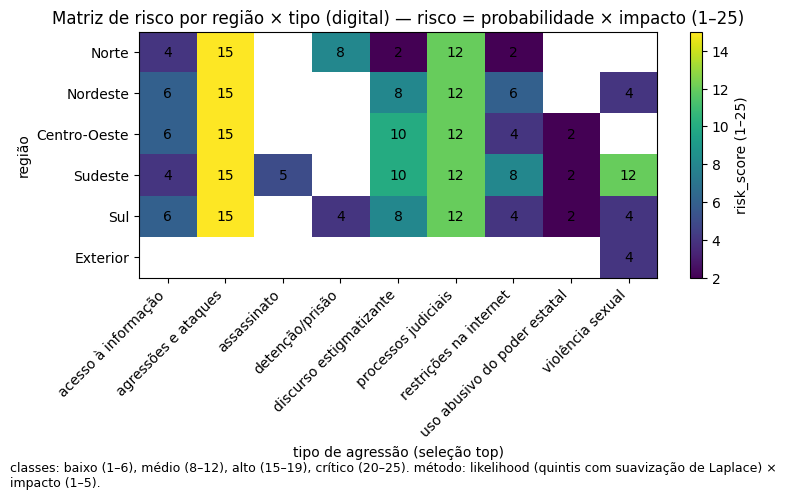

salvo em: matriz_risco_heatmap_fisico.png


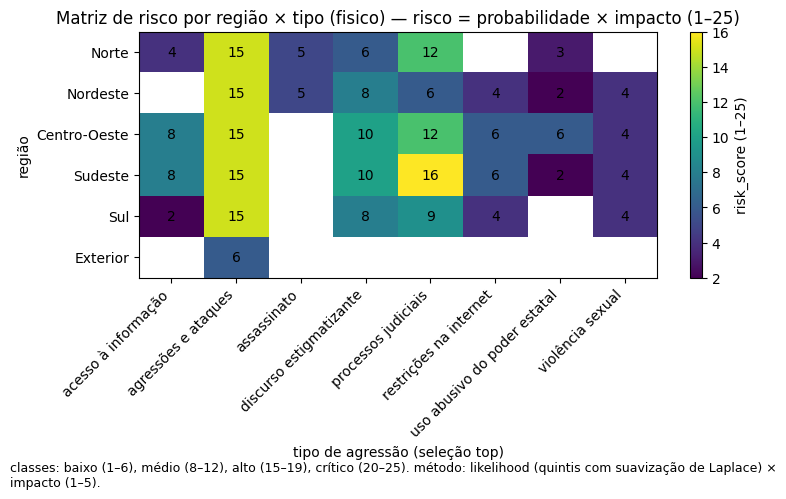

In [ ]:
# ============================================================
# Heatmap da matriz de risco (um gráfico por canal)
# Requisitos: 'out' com colunas: regiao_norm, tipo_agressao_norm, risk_score, risk_class, canal
# ============================================================

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _order_regions(vals):
    ordem = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul", "Exterior"]
    seen = [r for r in ordem if r in vals]
    # acrescenta quaisquer outras regiões que porventura existam
    seen += [r for r in vals if r not in seen]
    return seen

def _select_top_types(df_channel, top=12, by="risk_score"):
    """
    Seleciona 'top' tipos para colunas, para manter o gráfico legível.
    - by="risk_score": média de risco por tipo
    - by="N_contexto": soma de N_contexto por tipo (se existir)
    """
    base = df_channel.copy()
    if by == "N_contexto" and "N_contexto" in base.columns:
        s = base.groupby("tipo_agressao_norm")["N_contexto"].sum().sort_values(ascending=False)
    else:
        s = base.groupby("tipo_agressao_norm")["risk_score"].mean().sort_values(ascending=False)
    return s.index.tolist()[:top]

def plot_risk_heatmap(out_df, canal="digital", top_tipos=12, annotate=True, savepath=None):
    """
    Gera um heatmap de risk_score (1–25) por regiao_norm × tipo_agressao_norm para um 'canal'.
    - canal: "digital" ou "fisico" (ou valor presente na coluna 'canal')
    - top_tipos: limita o nº de colunas para legibilidade
    - annotate: escreve o score em cada célula
    - savepath: se fornecido, salva o PNG
    """
    dfc = out_df[out_df["canal"] == canal].copy()
    if dfc.empty:
        print(f"Nenhum dado para canal='{canal}'. Verifique a coluna 'canal' em 'out'.")
        return

    # escolher tipos mais relevantes para não poluir o eixo X
    tipos = _select_top_types(dfc, top=top_tipos, by="risk_score")
    dfc = dfc[dfc["tipo_agressao_norm"].isin(tipos)]

    # pivot: linhas = regiao, colunas = tipo, valores = risk_score
    mat = dfc.pivot_table(index="regiao_norm",
                          columns="tipo_agressao_norm",
                          values="risk_score",
                          aggfunc="mean")
    # ordena eixos
    mat = mat.reindex(index=_order_regions(mat.index.tolist()))
    mat = mat.reindex(columns=sorted(mat.columns.tolist()))

    # cria figura (um único gráfico)
    fig, ax = plt.subplots(figsize=(max(8, 0.8*mat.shape[1]), max(4, 0.8*mat.shape[0])))

    im = ax.imshow(mat.values, aspect="auto")  # sem definir cmap → usa padrão do matplotlib
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_xticklabels(mat.columns, rotation=45, ha="right")
    ax.set_yticklabels(mat.index)

    # grade leve (opcional; sem cores específicas)
    ax.set_title(f"Matriz de risco por região × tipo ({canal}) — risco = probabilidade × impacto (1–25)")
    ax.set_xlabel("tipo de agressão (seleção top)")
    ax.set_ylabel("região")

    # colorbar (sem escolher paleta)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("risk_score (1–25)")

    # anotações (scores)
    if annotate:
        data = mat.values
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                val = data[i, j]
                if not (isinstance(val, float) and math.isnan(val)):
                    ax.text(j, i, f"{int(round(val))}", ha="center", va="center")

    # legenda de classes (texto explicativo)
    plt.figtext(0.01, -0.02,
        "classes: baixo (1–6), médio (8–12), alto (15–19), crítico (20–25). "
        "método: likelihood (quintis com suavização de Laplace) × impacto (1–5).",
        wrap=True, fontsize=9)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
        print(f"salvo em: {savepath}")
    plt.show()

# ====== use: gere dois gráficos, um por canal ======
try:
    plot_risk_heatmap(out, canal="digital", top_tipos=12, annotate=True, savepath="matriz_risco_heatmap_digital.png")
    plot_risk_heatmap(out, canal="fisico",  top_tipos=12, annotate=True, savepath="matriz_risco_heatmap_fisico.png")
except NameError as e:
    print("Variável 'out' não encontrada. Execute primeiro a construção da matriz com 'build_risk_matrix(...)'.")
